In [1]:
import tqdm
import torch
import gpytorch
import linear_operator
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import time

from matplotlib import style
style.use('seaborn-white')

from numpy import genfromtxt
#gpytorch.settings.max_cg_iterations(2000)
from gpytorch.variational.nearest_neighbor_variational_strategy import NNVariationalStrategy

from torch.utils.data import TensorDataset, DataLoader

torch.set_default_dtype(torch.float64)
%matplotlib inline
%load_ext autoreload
%autoreload 2

/mnt/bgfs/belal/4232808/ipykernel_65210/2335421355.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


In [2]:
def cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt):
    theta_dd = ((m1+m2)*gravity*np.sin(theta)-np.cos(theta)*(force+m2*length*(theta_d**2)*np.sin(theta)-mu_c*x_d)-((m1+m2)*mu_p*theta_d)/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(np.cos(theta))**2)
    x_dd = (force-m2*length*(theta_dd*np.cos(theta)-(theta_d**2)*np.sin(theta))-mu_c*x_d) / (m1+m2)
    # Euler Integrator 
    x_d = x_d + x_dd*dt
    x = x + x_d*dt
    theta_d = theta_d + theta_dd*dt
    theta = theta + theta_d*dt
    return theta_dd, theta_d, theta, x_dd, x_d,  x 

In [3]:
# Uncertainty Sources 
m1 = 1 
m2 = 0.1
length = 0.5
k_inertia = 1/3
mu_c = 0.0005
mu_p = 0.000002
gravity = 9.8 
dt = 0.01

# Initialization 
theta = 0.3 # np.random.uniform(low=-0.05, high=0.05)
theta_d = 1 # np.random.uniform(low=-0.05, high=0.05)
x = 0 # np.random.uniform(low=-0.05, high=0.05)
x_d = 0 # np.random.uniform(low=-0.05, high=0.05)

# lists for storing results 
theta_dd_sim = []           # theta double derivative 
theta_d_sim = [theta_d]     # theta derivative 
theta_sim = [theta]         # theta  
x_dd_sim = []               # x double derivative 
x_d_sim = [x_d]             # x derivative 
x_sim = [x]                 # x

noOfSteps = 12000
ts = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

for i in range(noOfSteps):
    force = 0.5*np.sin(6*ts[i]) #-0.2+
    #force = -1+np.sin(ts[i])+3*np.sin(2*ts[i])
    #force = -0.5+0.2*np.sin(ts[i])+0.3*np.sin(2*ts[i])
    theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt)
    theta_dd_sim.append(theta_dd)
    theta_d_sim.append(theta_d)
    theta_sim.append(theta)
    x_dd_sim.append(x_dd)
    x_d_sim.append(x_d)
    x_sim.append(x)

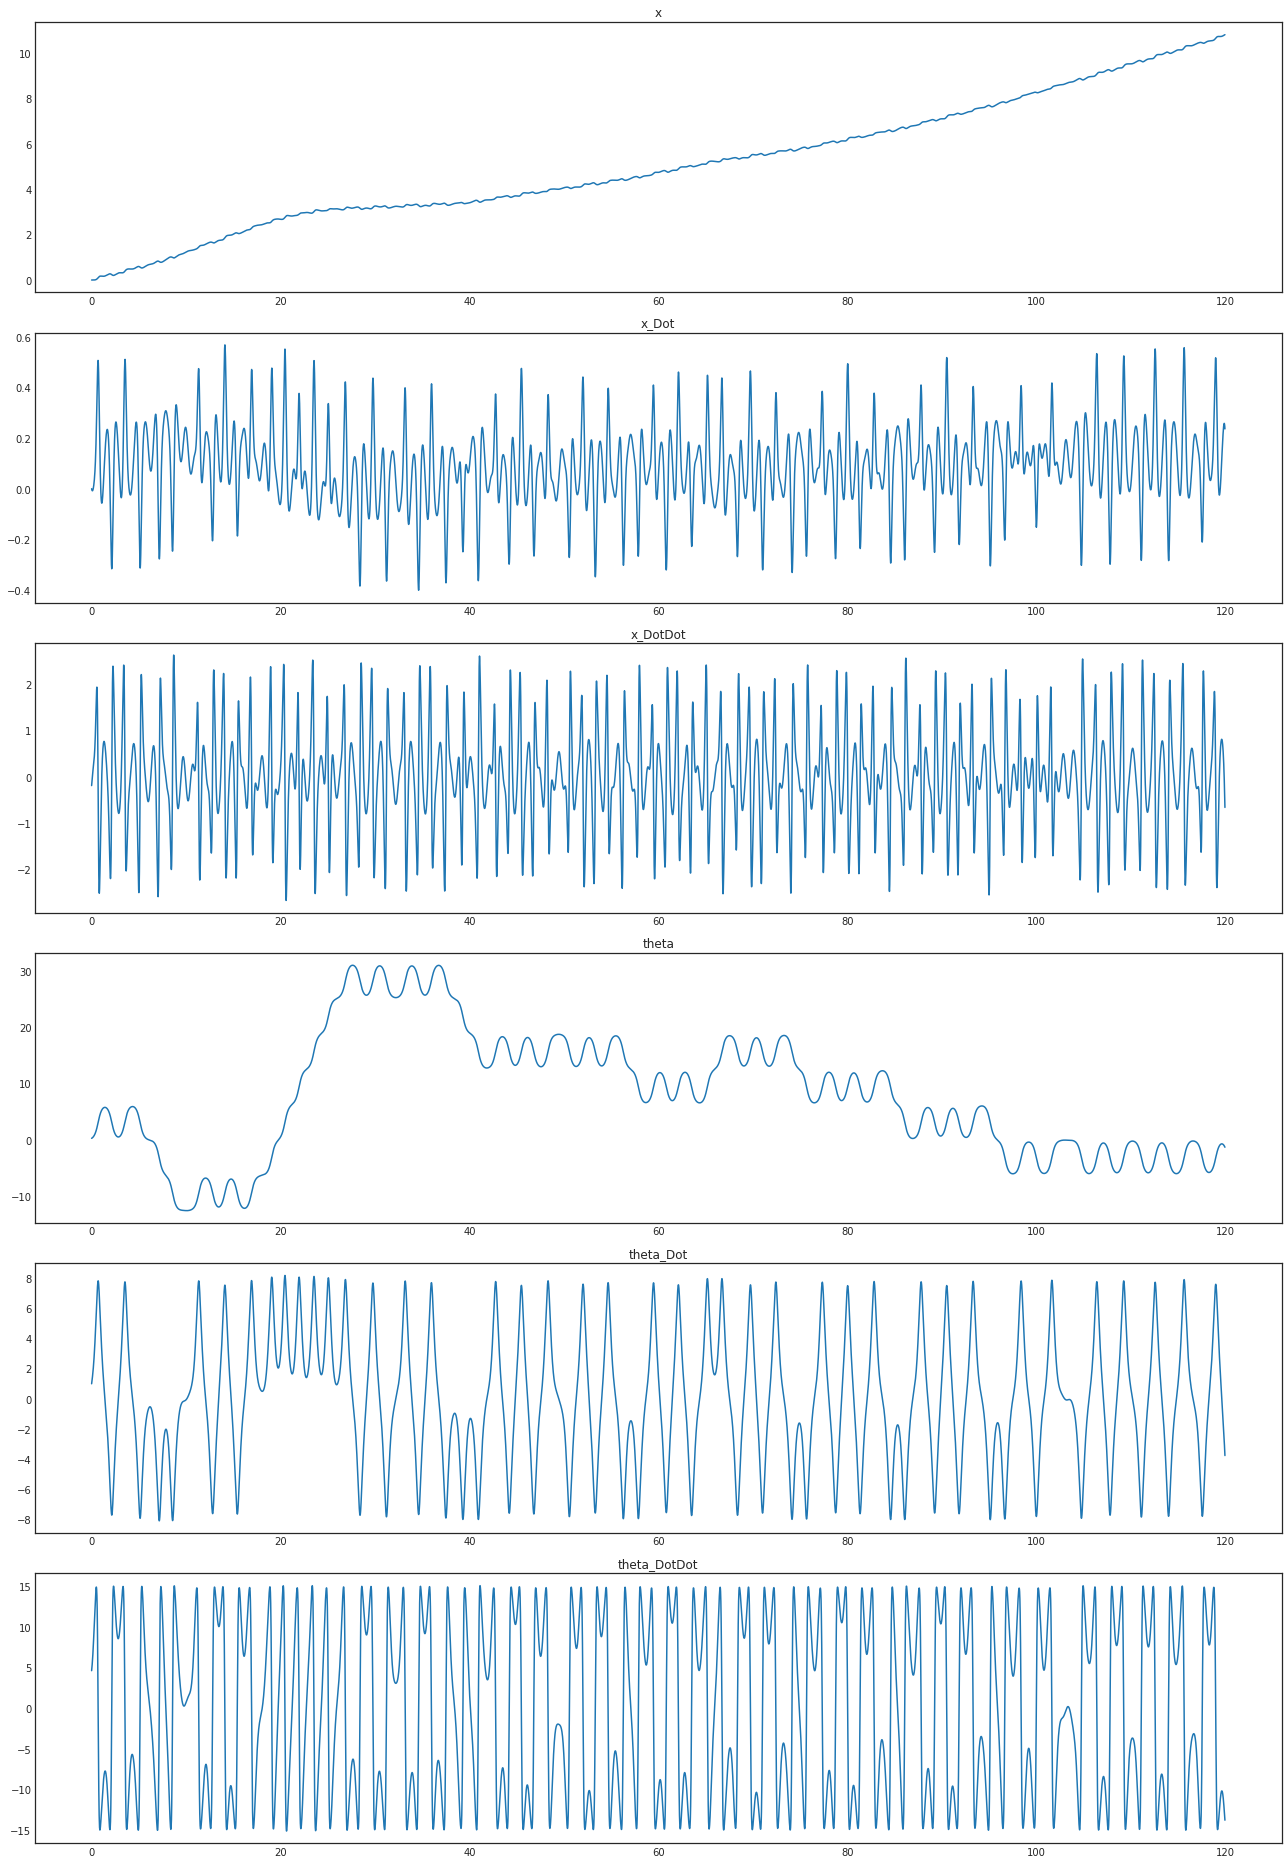

In [4]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

dt = 0.01
noOfSteps = 12000
timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False) # for plotting 

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

Text(0.5, 1.0, 'A single plot')

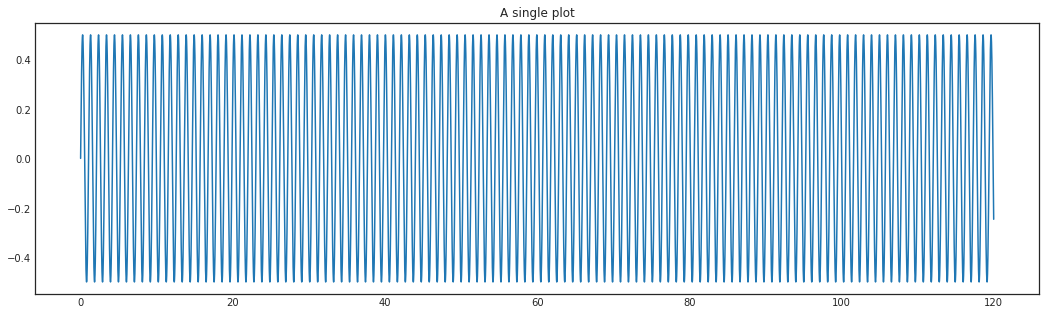

In [5]:
# Force Input Plot 
forceIn = 0.5*np.sin(6*timeSteps) #-0.2+
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(18)

ax.plot(timeSteps[startTraj:endTraj], forceIn[startTraj:endTraj])
ax.set_title('A single plot')

In [6]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)
#X_train = np.stack(((theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

Y_theta = ((theta_dd_sim-theta_dd_sim_mean)/theta_dd_sim_stdev)
Y_x = ((x_dd_sim-x_dd_sim_mean)/x_dd_sim_stdev)
X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [7]:
# Numpy to tensors 
X_train = torch.from_numpy(X_train).double()
Y_train_theta = torch.from_numpy(Y_train_theta).double()
Y_train_x = torch.from_numpy(Y_train_x).double()
X_prior = torch.from_numpy(X_prior).double()
Y_theta = torch.from_numpy(Y_theta).double()
Y_x = torch.from_numpy(Y_x).double()

# Putting tensors on GPU
if torch.cuda.is_available():
    X_train, Y_train_theta, Y_train_x, X_prior, Y_theta, Y_x = X_train.cuda(), Y_train_theta.cuda(), Y_train_x.cuda(), X_prior.cuda(), Y_theta.cuda(), Y_x.cuda()

In [8]:
#train_dataset = TensorDataset(X_train, Y_train_theta)
#train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

#test_dataset = TensorDataset(X_prior, Y_theta)
#test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [9]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, likelihood, k=256, training_batch_size=256):
        m, d = inducing_points.shape
        self.m = m
        self.k = k

        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(m)

        #if torch.cuda.is_available():
        #    inducing_points = inducing_points.cuda()

        variational_strategy = NNVariationalStrategy(self, inducing_points, variational_distribution, k=k,
                                                     training_batch_size=training_batch_size)
        #print(variational_strategy.nn_xinduce_idx.to(variational_strategy.inducing_points.device))
        #print(variational_strategy.inducing_points.device)
        #kl_indices1 = variational_strategy._get_training_indices()
        #print(variational_strategy.nn_xinduce_idx[..., kl_indices1 - variational_strategy.k, :].to(variational_strategy.inducing_points.device))
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=d)

        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, prior=False, **kwargs):
        if x is not None:
            if x.dim() == 1:
                x = x.unsqueeze(-1)
        return self.variational_strategy(x=x, prior=False, **kwargs)

k = 1200
training_batch_size = 64
    
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(0.15, 1.5, sigma=0.001))
# Note: one should use full training set as inducing points!
model = GPModel(inducing_points=X_train, likelihood=likelihood, k=k, training_batch_size=training_batch_size)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [10]:
num_epochs = 1500
num_batches = model.variational_strategy._total_training_batches


model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=X_train.size(0))
losses = []

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for epoch in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(range(num_batches), desc="Minibatch", leave=False, disable=True)
    
    for i in minibatch_iter:
        with linear_operator.settings.max_cg_iterations(100000), linear_operator.settings.cholesky_jitter(1e-1):
            optimizer.zero_grad()
            output = model(x=None)
            # Obtain the indices for mini-batch data
            current_training_indices = model.variational_strategy.current_training_indices
            # Obtain the y_batch using indices. It is important to keep the same order of train_x and train_y
            y_batch = Y_train_theta[current_training_indices]
            if torch.cuda.is_available():
                y_batch = y_batch.cuda()
            loss = -mll(output, y_batch)
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            optimizer.step()
    losses.append(loss.item())
    if epoch%100==0:
        print(loss.item())  

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

36299.68742607813
7.4074435284684075
1.4880343963509355
1.373379892376417
1.2828375129145009
1.3192089902068722
1.3380465599006826
1.4202593847996774
1.425579086612652
1.3250276497023963
1.4363567693563388
1.5388793810985788
1.3354597622080433
1.3227038086558545
1.2546592520100577


In [12]:
#torch.save(model.state_dict(), '../../learnedModels/deterministicCase/VNNGPwithGPyTorch/VNNGP(Train1500k)(Batch64)(k1500)ForceIn')   

In [10]:
model.load_state_dict(torch.load('../../learnedModels/deterministicCase/VNNGPwithGPyTorch/VNNGP(Train1500k)(Batch64)(k1500)ForceIn'))

model.eval()
likelihood.eval() 

means = np.zeros(X_prior.shape[0])
lowers = np.zeros(X_prior.shape[0])
uppers = np.zeros(X_prior.shape[0])

with torch.no_grad():
    i = 0
    #for x_batch, y_batch in test_loader:
    preds = model(X_prior)
    lower, upper = preds.confidence_region()
    means = preds.mean.cpu().numpy()
    lowers = lower.cpu().numpy()
    uppers = upper.cpu().numpy()

In [16]:
model.load_state_dict(torch.load('../../learnedModels/deterministicCase/VNNGPwithGPyTorch/VNNGP(Train1500k)(Batch64)(k1500)ForceIn'))

model.eval()
likelihood.eval() 

means = np.zeros(X_prior.shape[0])
lowers = np.zeros(X_prior.shape[0])
uppers = np.zeros(X_prior.shape[0])

for i in range(24):
    with torch.no_grad():
        #for x_batch, y_batch in test_loader:
        preds = model(X_prior[:500,:])
        lower, upper = preds.confidence_region()
        means[500*i:500+500*i] = preds.mean.cpu().numpy()
        lowers[500*i:500+500*i] = lower.cpu().numpy()
        uppers[500*i:500+500*i] = upper.cpu().numpy()
        torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

In [17]:
allData = np.stack((means, lowers, uppers, Y_theta.cpu()), axis=1)
np.savetxt('../../../Results/deterministicCase/VNNGPwithGPyTorch/VNNGP(Train1500k)(Batch64)(k1500)ForceIn.csv', allData, delimiter=',')

In [20]:
#lossData = np.array(losses)
#np.savetxt('../../../Results/deterministicCase/VNNGPwithGPyTorch/VNNGP(Train1500k)(Batch64)(k1500)ForceInLoss.csv', lossData, delimiter=',')

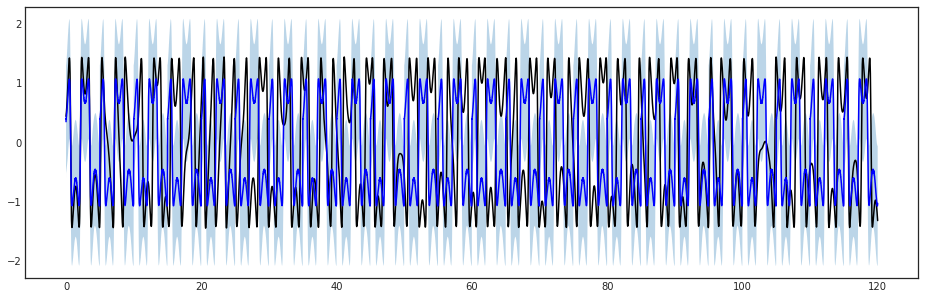

In [21]:
start_traj = 0
end_traj = 12000

fig, ax = plt.subplots(1)

fig.set_figheight(5)
fig.set_figwidth(16)

ax.plot(timeSteps[start_traj:end_traj], Y_theta[start_traj:end_traj].cpu().numpy(), 'k')
ax.plot(timeSteps[start_traj:end_traj], means[start_traj:end_traj], 'b')
ax.fill_between(timeSteps[start_traj:end_traj], lowers[start_traj:end_traj], uppers[start_traj:end_traj], alpha=0.3)
#ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.savefig('../../../Results/deterministicCase/VNNGPwithGPyTorch/VNNGP(Train1500k)(Batch64)(k1500)ForceIn.png')

In [13]:
mean_squared_error(means, Y_theta[start_traj:end_traj].cpu().numpy(), squared=False)

NameError: name 'means' is not defined